In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

cust_filter = data['cust_id'] == 'klant_69'
data = data.where(cust_filter).dropna()


data['procesdag']=pd.to_datetime(data['procesdag'])
data.set_index('procesdag', inplace=True)
data = data['2019-01-01':'2019-04-01']

data.head()

,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
procesdag,,,,
2019-01-01,klant_69,0.0,877.0,train
2019-01-02,klant_69,877.0,637.0,train
2019-01-03,klant_69,637.0,591.0,train
2019-01-04,klant_69,591.0,0.0,train
2019-01-05,klant_69,0.0,1043.0,train


In [2]:
data.head()

,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
procesdag,,,,
2019-01-01,klant_69,0.0,877.0,train
2019-01-02,klant_69,877.0,637.0,train
2019-01-03,klant_69,637.0,591.0,train
2019-01-04,klant_69,591.0,0.0,train
2019-01-05,klant_69,0.0,1043.0,train


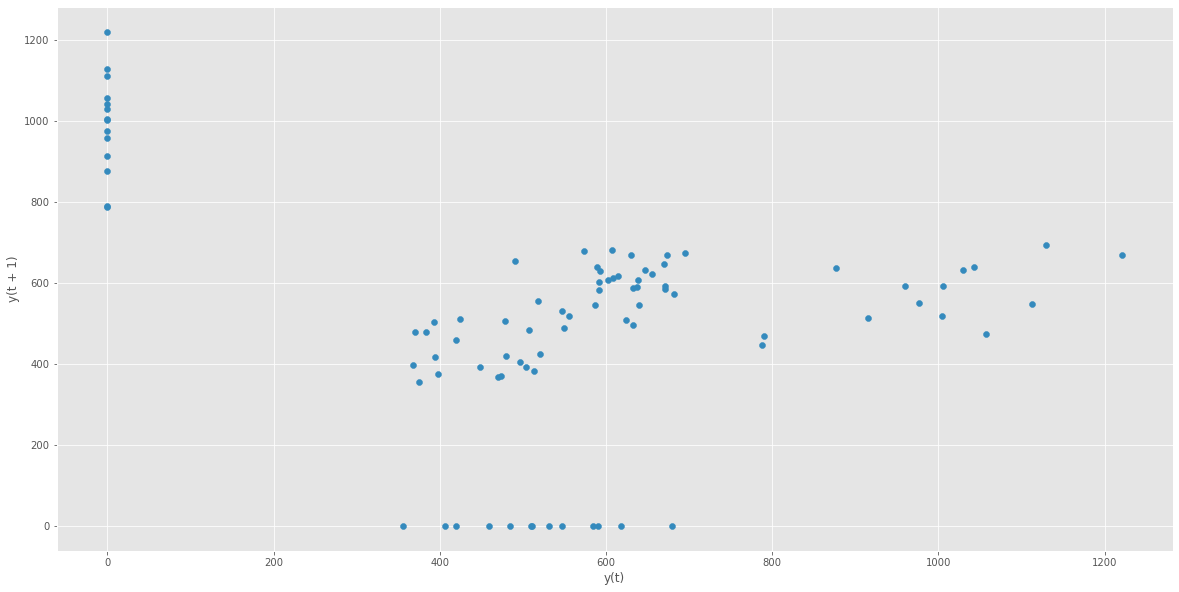

In [3]:
pd.plotting.lag_plot(data['aantal_pakketten'])

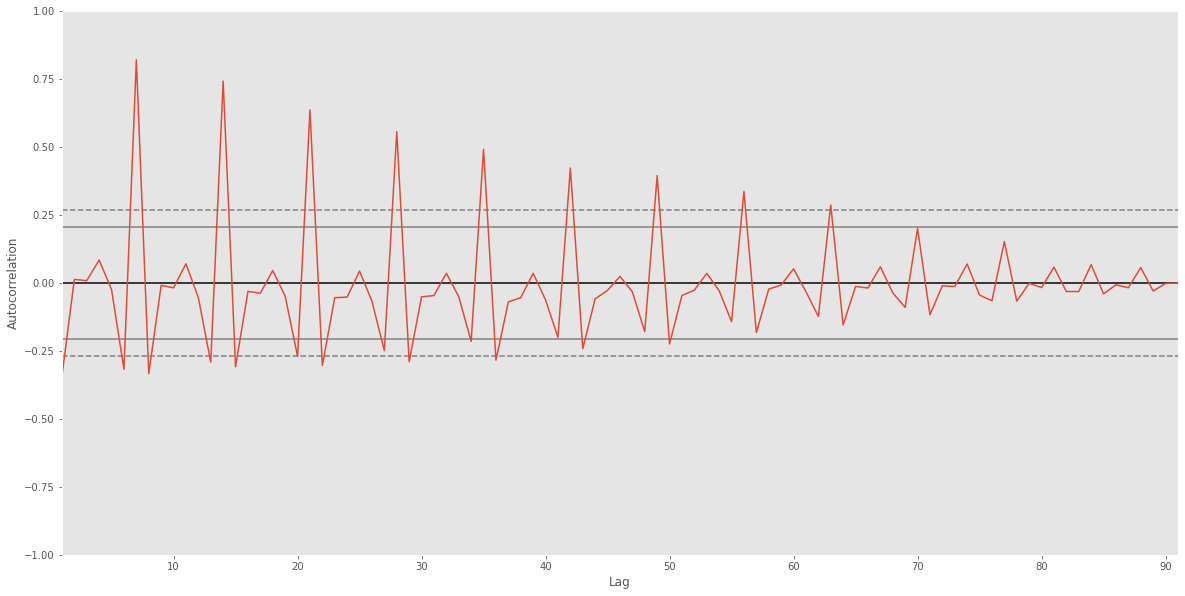

In [4]:
pd.plotting.autocorrelation_plot(data['aantal_pakketten'])

In [5]:
data['aantal_pakketten'].corr(data['aantal_pakketten'].shift(7))

0.908117134896638

In [6]:
# data['stationary'] = data['aantal_pakketten'].diff()
# data['stationary']

In [7]:
from statsmodels.tsa.ar_model import AR

# Train/Test datasets
X = data['aantal_pakketten'].dropna()
train_data = X[:-7]
test_data = X[-7:]

In [8]:
data.shape

(91, 4)

In [9]:
train_data.shape

(84,)

In [10]:
test_data.shape

(7,)

In [11]:
train_data

procesdag
2019-01-01       0.0
2019-01-02     877.0
2019-01-03     637.0
2019-01-04     591.0
2019-01-05       0.0
               ...  
2019-03-21     507.0
2019-03-22     485.0
2019-03-23       0.0
2019-03-24    1030.0
2019-03-25     633.0
Name: aantal_pakketten, Length: 84, dtype: float64

In [12]:
test_data

procesdag
2019-03-26    589.0
2019-03-27    640.0
2019-03-28    547.0
2019-03-29    531.0
2019-03-30      0.0
2019-03-31    977.0
2019-04-01    552.0
Name: aantal_pakketten, dtype: float64

In [13]:
# Train AR model
model = AR(train_data)
model_fitted = model.fit()

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWa

In [14]:
print('The lag value chose is: %s' % model_fitted.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted.params)

The lag value chose is: 11
The coefficients of the model are:
 const                   145.019566
L1.aantal_pakketten       0.224940
L2.aantal_pakketten       0.281389
L3.aantal_pakketten       0.032833
L4.aantal_pakketten      -0.048290
L5.aantal_pakketten      -0.044685
L6.aantal_pakketten      -0.041255
L7.aantal_pakketten       0.910904
L8.aantal_pakketten      -0.275647
L9.aantal_pakketten      -0.324571
L10.aantal_pakketten     -0.039336
L11.aantal_pakketten      0.041554
dtype: float64


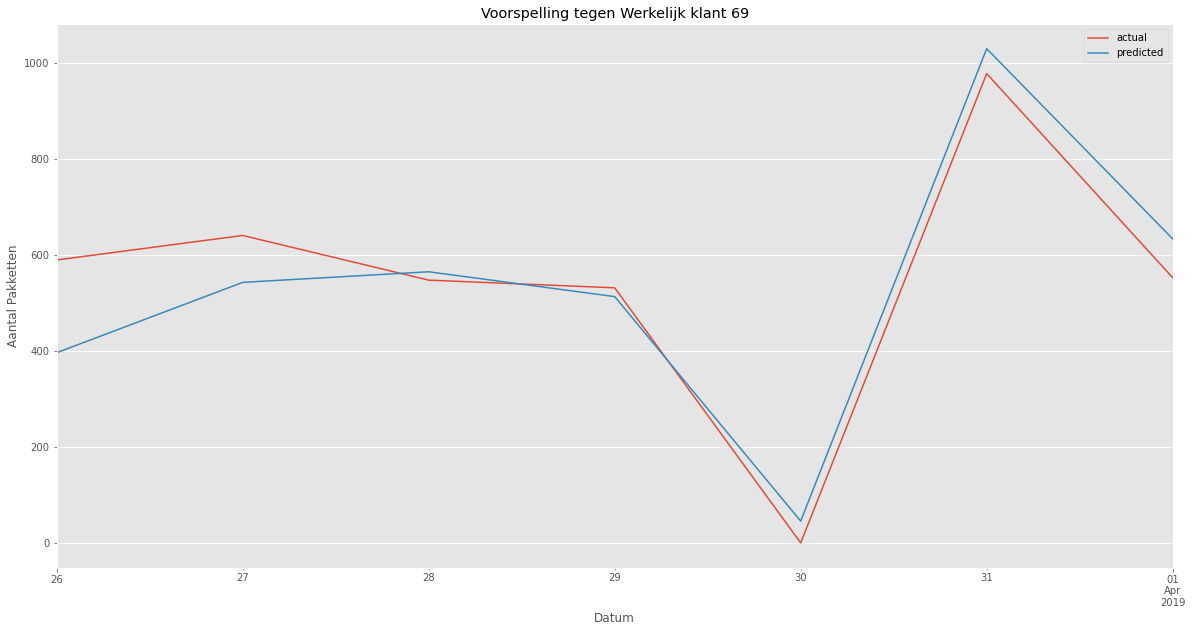

In [15]:
# make predictions
predictions = model_fitted.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False)

# create comparison dataframe
compare_data = pd.concat([data['aantal_pakketten'].tail(7), predictions], axis=1).rename(columns={'aantal_pakketten':'actual', 0:'predicted'})

compare_data.plot(
ylabel = 'Aantal Pakketten',
xlabel = 'Datum',
title = 'Voorspelling tegen Werkelijk klant 69')

In [16]:
compare_data

,actual,predicted
2019-03-26,589.0,395.940360
2019-03-27,640.0,542.339814
2019-03-28,547.0,564.442316
2019-03-29,531.0,512.708347
2019-03-30,0.0,45.371103
2019-03-31,977.0,1028.807303
2019-04-01,552.0,632.889807


In [17]:
diff = compare_data.actual - compare_data.predicted

Text(0, 0.5, '$\\hat{y}$')

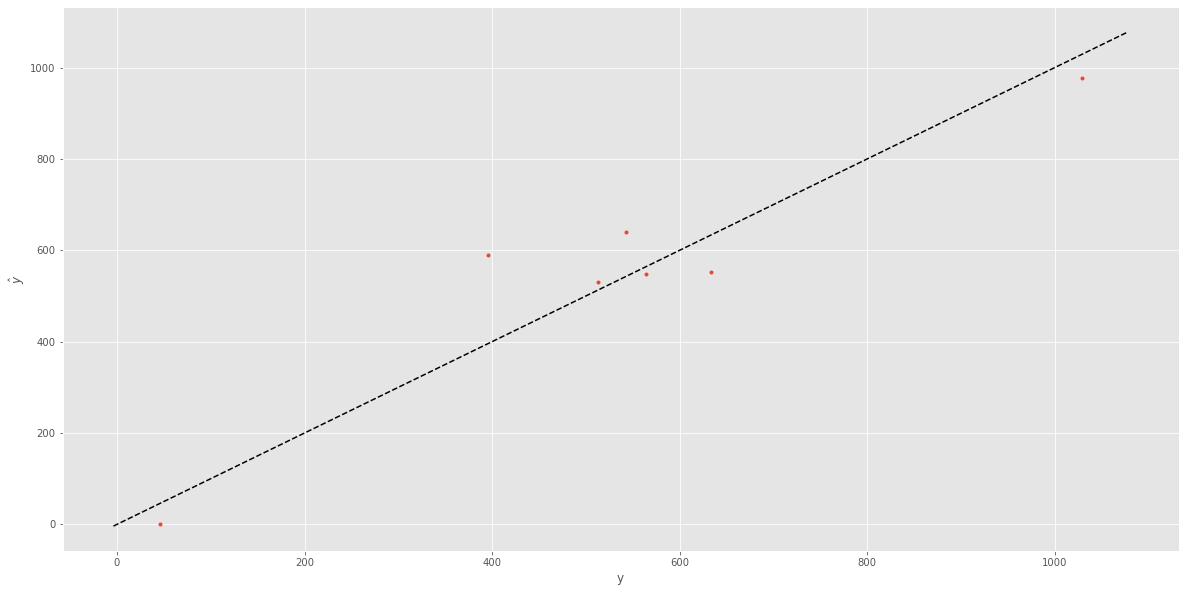

In [18]:
plt.plot(compare_data.predicted, compare_data.actual, ".")
plt.plot(plt.xlim(), plt.xlim(), ls="--", c='black')
plt.xlabel("y")
plt.ylabel("$\hat{y}$")

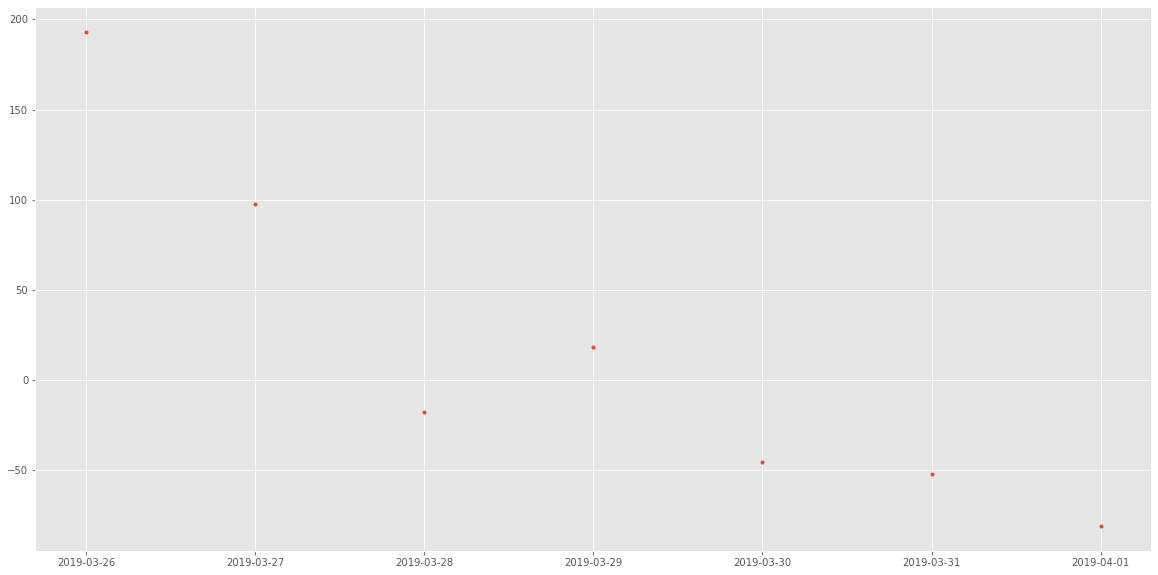

In [19]:
plt.plot(diff, ".")

(array([1., 2., 1., 1., 0., 0., 1., 0., 0., 1.]),
 array([-80.88980708, -53.4948624 , -26.09991773,   1.29502694,
         28.68997162,  56.08491629,  83.47986096, 110.87480564,
        138.26975031, 165.66469498, 193.05963966]),
 <a list of 10 Patch objects>)

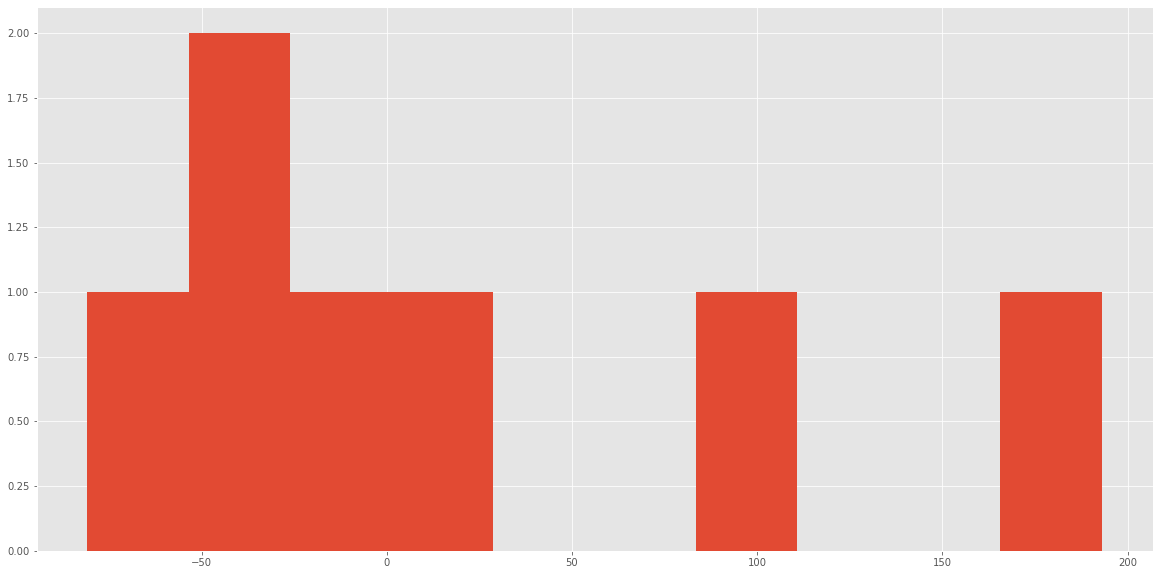

In [20]:
plt.hist(diff)